# Kaggle Korea 2019 집값 예측하기

- (5-4) Baseline 커널에는 다양한 시각화 코드가 있기 때문에 
- 노트북의 맨 위에 아래의 코드를 실행시켜서 시각화 그래프가 나타날 수 있도록 합니다

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('얍💢')

얍💢


- (5-5) 프로젝트 디렉토리(~/aiffel/kaggle_kakr_housing) 내 data 폴더에 있는 파일 사용

In [2]:
# 구글드라이브에서 데이터 파일 읽어오기 위한 코드
#from google.colab import drive
#drive.mount('/content/drive')


In [3]:
# 아이펠 폴더 파일 경로 지정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

# 구글 드라이브 파일 경로 지정
#data_dir = '/content/drive/MyDrive/AIFFEL/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)


/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.




### 1-1. 데이터 불러오기
- 데이터를 data(학습용 데이터), sub(결과 예측용 데이터, 즉 시험문제)이라는 변수로 불러옵니다.

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))
print(data.columns)
print(sub.columns)

train data dim : (15035, 21)
sub data dim : (6468, 20)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 1-2. 데이터 구성 확인

| # | 열 이름 | 내용 | 비고 |
|-----:|-----|-----|-----|
| 1 | ID | 집을 구분하는 번호 | |
| 2 | date | 집을 구매한 날짜 | |
| 3 | price | 타겟 변수인 집의 가격 | 테스트 데이터(sub)에는 없음 |
| 4 | bedrooms | 침실의 수 | |
| 5 |  bathrooms | 침실당 화장실 개수 | |
| 6 |  sqft_living | 주거 공간의 평방 피트 | |
| 7 |  sqft_lot | 부지의 평방 피트 | |
| 8 | floors | 집의 층 수 | |
| 9 | waterfront | 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰) | |
| 10 | view | 집이 얼마나 좋아 보이는지의 정도 | |
| 11 | condition | 집의 전반적인 상태 | |
| 12 | grade | King County Grading 시스템 기준으로 매긴 집의 등급 | |
| 13 | sqft_above | 지하실을 제외한 평방 피트 | |
| 14 | sqft_basement | 지하실의 평방 피트 | |
| 15 | yr_built | 집을 지은 연도 | |
| 16 | yr_renovated | 집을 재건축한 연도 | |
| 17 | zipcode | 우편번호 | |
| 18 | lat | 위도 | |
| 19 | long | 경도 | |
| 20 | sqft_living15 | 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) | |
| 21 | sqft_lot15 | 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) | |


### 1-3. 학습데이터(data)에서 라벨(price 컬럼) 제거하기
- price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼은 지워줍니다.
  - 참고로 데이터 분석 과정에서 칼럼을 없애고 싶다면 pandas.DataFrame.drop도 사용할 수 있습니다.

In [5]:
y = data['price']
del data['price']

print(data.shape)
print(data.columns)

(15035, 20)
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 1-4. 학습데이터(data)와 결과예측용데이터(sub) 합치기
- 모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐봅니다.
  - 물론, 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 
  - 데이터를 합치기 전 train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용합니다.

In [6]:
train_len = len(data)
print("합치기 전 학습데이터 개수: ", len(data))

data = pd.concat((data, sub), axis=0)

print("합친 후 총 데이터 개수: ", len(data))

합치기 전 학습데이터 개수:  15035
합친 후 총 데이터 개수:  21503


In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.


### 2-1. 결측치 확인
- missingno 라이브러리의 matrix 함수를 사용, 데이터의 결측 상태 시각화

<AxesSubplot:>

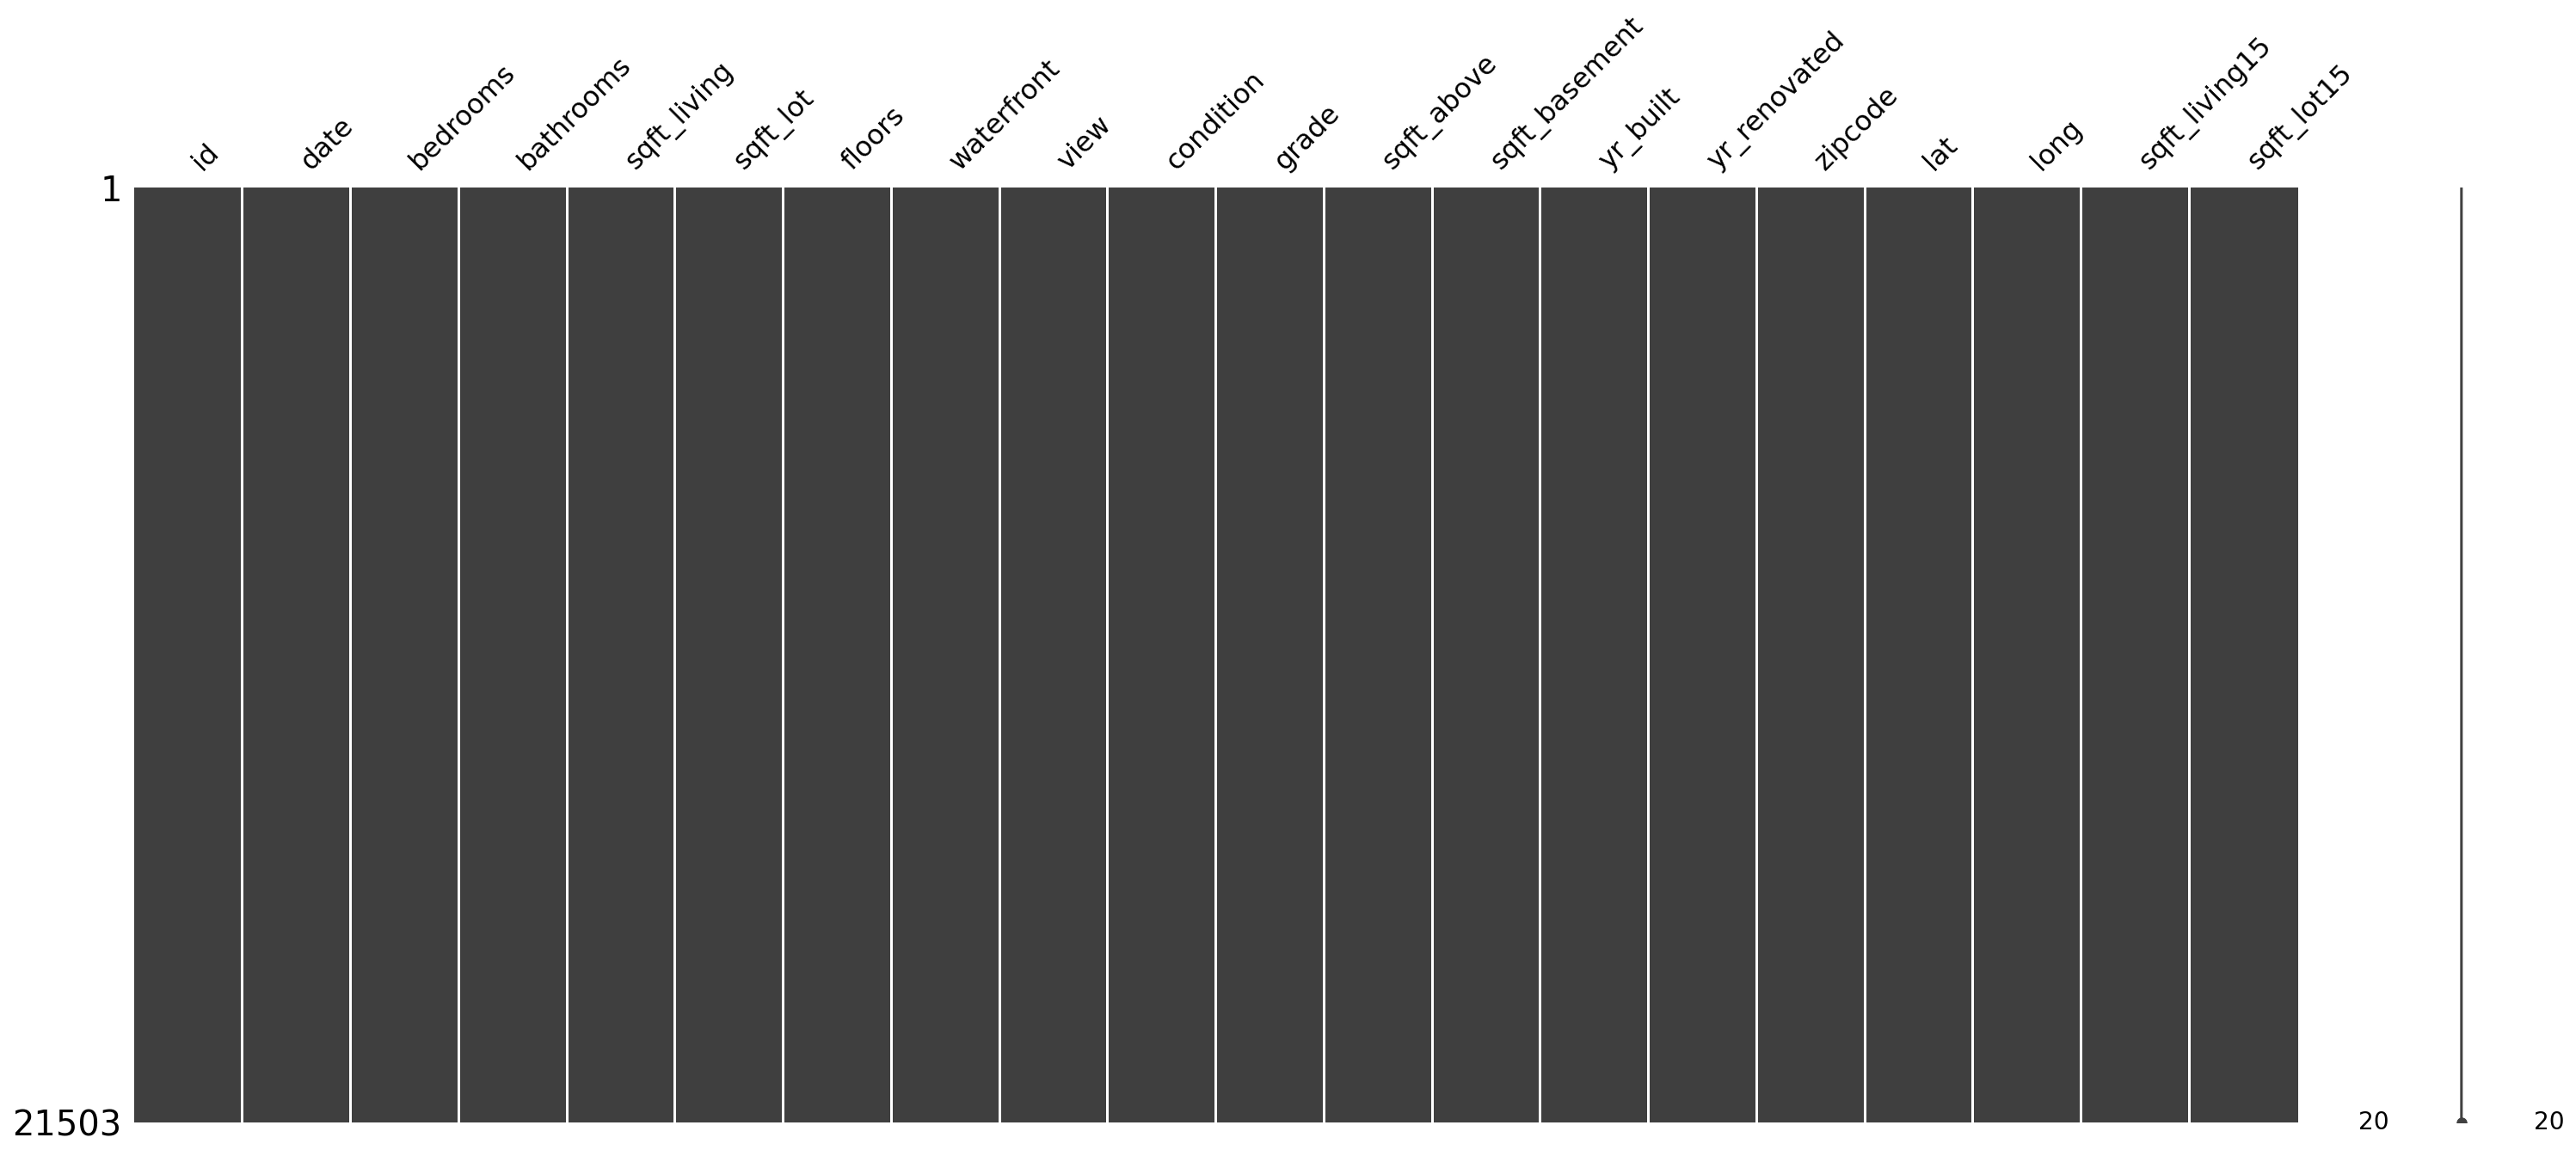

In [8]:
msno.matrix(data)

- 위에 출력된 것은 data라는 DataFrame을 매트릭스 모양 그대로 시각화한 것
- 만약 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옴
- 결측치가 없다면 매트릭스 전체가 까맣게 나옴: **결측치 없음**

### 2-2. 결측치 개수 다시 확인하기

- 아래와 같이 직접 결측치의 개수를 출력해서 확인할 수도 있습니다.
  - 우선 id를 가지고 데이터프레임 인덱싱을 적용해 사용법을 익혀봅시다.
- 천천히 진행하면 3단계를 거칩니다.
  1. id컬럼이 결측치인지 확인합니다.
  2. 결측치인 데이터만 뽑아냅니다.
  3. 결측치인 데이터의 개수를 셉니다.
코드를 하나하나 작성해 볼까요?

In [9]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


- True와 False로 이루어진 데이터프레임 출력
- 인덱싱!!! 데이터프레임을 이용해서 데이터프레임으로부터 원하는 값을 가져오는 아주 훌륭한 기능

In [10]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

- 결측치가 없기 때문에 빈 데이터프레임이 나옴
- 인덱싱을 이용하면 데이터프레임을 그대로 사용할 수 있다는 것이 매우 큰 장점임
- 인덱싱 기능이 없었더라면 항상 데이터프레임을 배열로 바꾸고 for문을 사용해야.  인덱싱 기능이 속도면에서도 월등히 빠름
- 이제 마지막으로 데이터 개수를 출력해주면 결측치 개수를 확인

In [11]:
# 3. 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [12]:
# 한 번에 뿅!
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


id 컬럼 외에도 모든 컬럼에 적용해야 하니 for문을 사용하면 완성입니다!

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [13]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2-3. id 변수 정리
- id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거
- 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼 저장 후 삭제

In [14]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)
print(len(data.columns))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
19


### 2-4. date 변수 정리
- date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 **정수형 변수**로 변경 (date도 예측을 위한 특성으로 활용 가능)
  - date 컬럼은 apply 함수로 필요한 부분만 자름

In [15]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2-5. 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.
- 각 컬럼(변수)의 범위(최소값~최대값) 확인

In [16]:
for c in data.columns:
    print(c, ":  ", min(data[c]), "~", max(data[c]))

date :   201405 ~ 201505
bedrooms :   0 ~ 33
bathrooms :   0.0 ~ 8.0
sqft_living :   290 ~ 13540
sqft_lot :   520 ~ 1651359
floors :   1.0 ~ 3.5
waterfront :   0 ~ 1
view :   0 ~ 4
condition :   1 ~ 5
grade :   1 ~ 13
sqft_above :   290 ~ 9410
sqft_basement :   0 ~ 4820
yr_built :   1900 ~ 2015
yr_renovated :   0 ~ 2015
zipcode :   98001 ~ 98199
lat :   47.1559 ~ 47.7776
long :   -122.519 ~ -121.315
sqft_living15 :   399 ~ 6210
sqft_lot15 :   651 ~ 871200


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

In [18]:
data.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,201438.639539,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,44.281419,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,201405.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,201407.000000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,201410.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,201502.000000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,201505.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


- 전체 데이터들의 분포를 확인합니다.
- 특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.
<br> <br>
- 아래 시각화 코드를 통해 **id 컬럼을 제외한 19개 컬럼**에 대해 한 번에 모든 그래프를 그려줍니다.
- 9행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용하고 있군요.
<br> <br>
- 그래프의 종류는 sns.kdeplot을 사용합니다.
- kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.

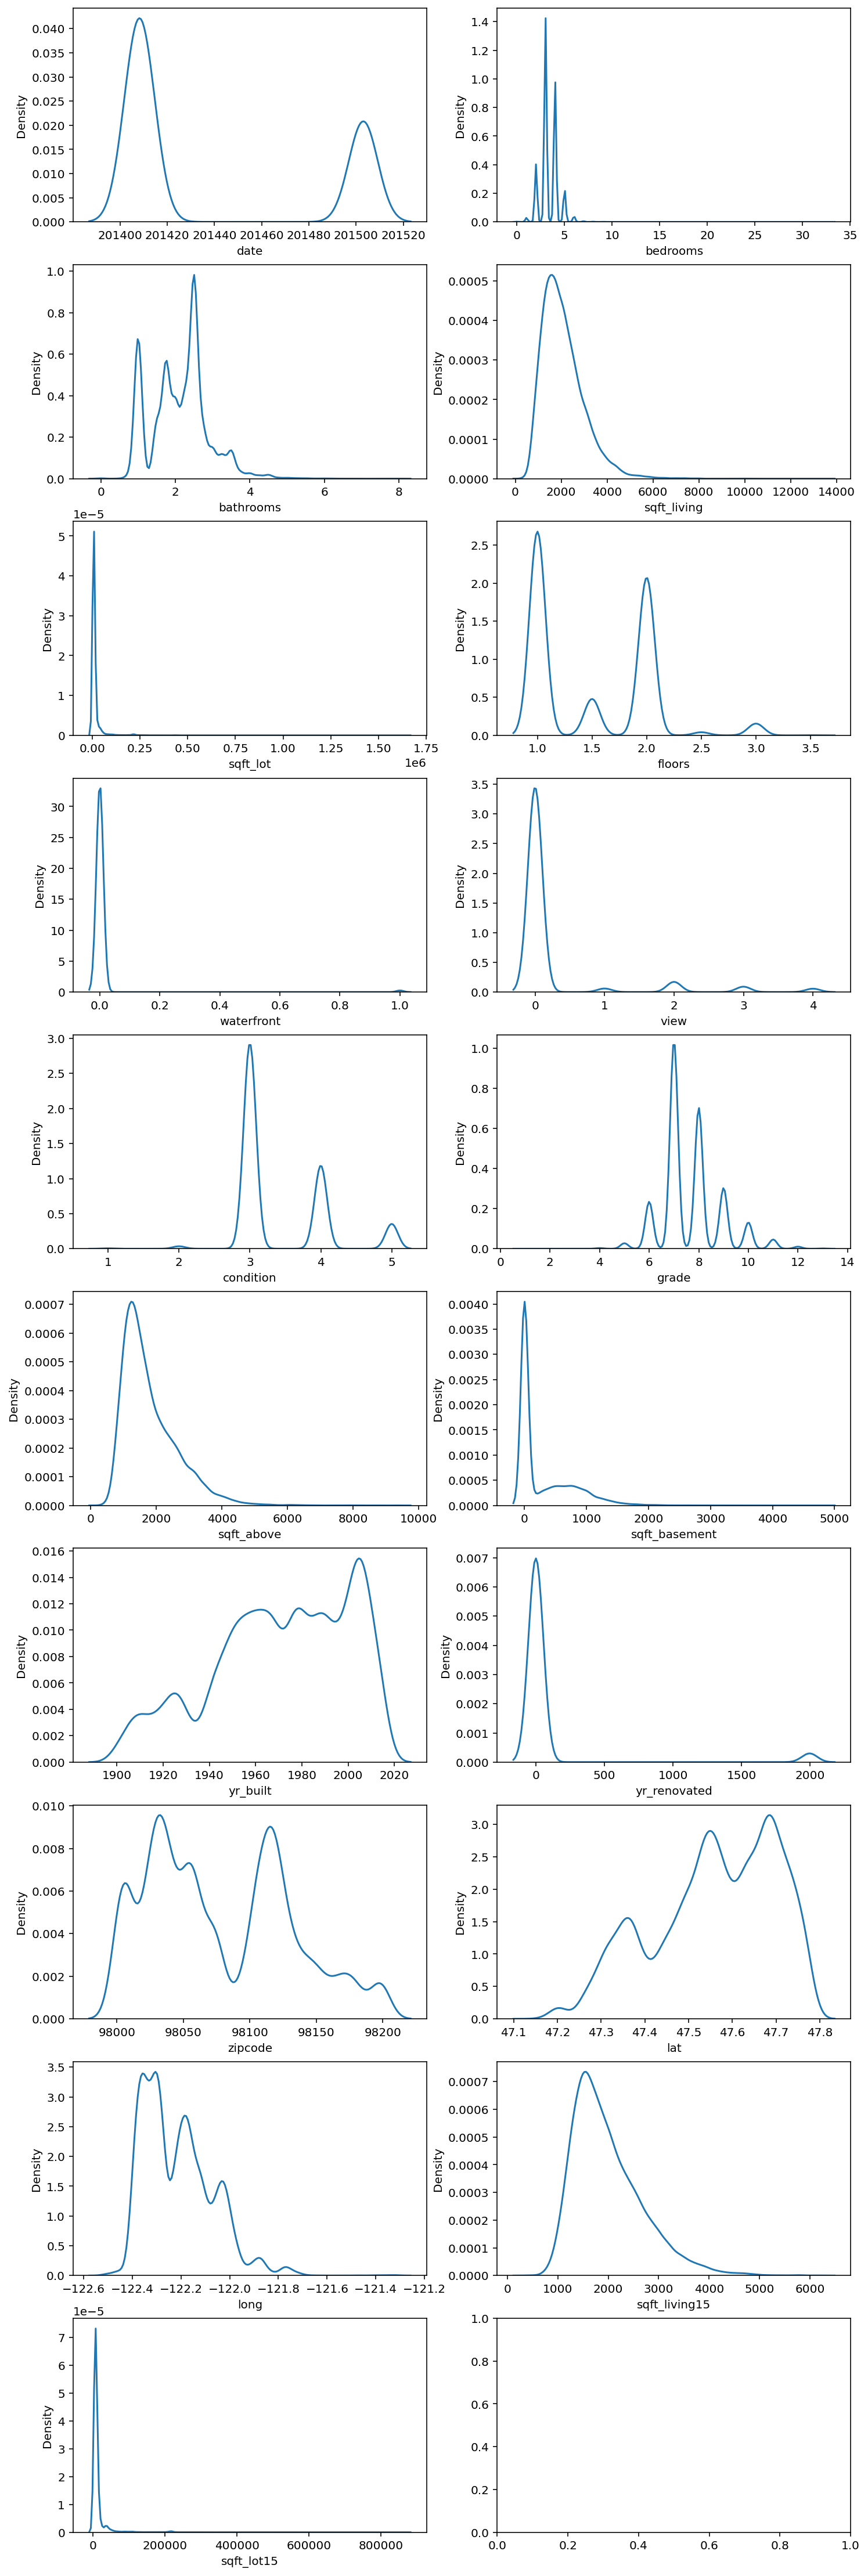

In [19]:
# <아이펠 코드>
fig, ax = plt.subplots(10, 2, figsize=(12, 40)) # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        #ax[row][col].set_title(columns[count], fontsize=10)
        count+=1
        if count == 19 :
            break



| # | 열 이름 | 내용 | 데이터 범위 | 데이터 분포 | 비고 |
|-----:|-----|-----|:-----:|:-----:|-----|
| 1 | ID | 집을 구분하는 번호 |N/A |N/A | |
| 2 | date | 집을 구매한 날짜 |201405 ~ 201505 |양봉 | |
| 3 | price | 타겟 변수인 집의 가격 | 78000 ~ 7700000 | 왼쪽 극도 치우침 | 테스트 데이터(sub)에는 없음 |
| 4 | bedrooms | 침실의 수 | 0 ~ 33 | 왼쪽 극도 치우침 | |
| 5 |  bathrooms | 침실당 화장실 개수 |0.0 ~ 8.0 | 왼쪽 치우침 | |
| 6 |  sqft_living | 주거 공간의 평방 피트 | 290 ~ 13540| 왼쪽 극도 치우침 | |
| 7 |  sqft_lot | 부지의 평방 피트 | 520 ~ 1651359 | 왼쪽 극도 치우침 | 이상데이터(outlier) 포함 의심됨 |
| 8 | floors | 집의 층 수 | 1.0 ~ 3.5 | 왼쪽 치우침, 양봉 | |
| 9 | waterfront | 집의 전방에 강이 흐르는지 유무<br> (a.k.a. 리버뷰) |0 ~ 1 |왼쪽 극도 치우침| |
| 10 | view | 집이 얼마나 좋아 보이는지의 정도 |0 ~ 4 |왼쪽 극도 치우침| |
| 11 | condition | 집의 전반적인 상태 |1 ~ 5 |보통| |
| 12 | grade | King County Grading 시스템 기준으로 <br> 매긴 집의 등급 | 1 ~ 13 |보통 | |
| 13 | sqft_above | 지하실을 제외한 평방 피트 | 290 ~ 9410 |왼쪽 극도 치우침| |
| 14 | sqft_basement | 지하실의 평방 피트 | 0 ~ 4820 |왼쪽 극도 치우침| |
| 15 | yr_built | 집을 지은 연도 | 1900 ~ 2015 | 보통 | |
| 16 | yr_renovated | 집을 재건축한 연도 | 0 ~ 2015 |왼쪽 극도 치우침| |
| 17 | zipcode | 우편번호 | 98001 ~ 98199 | 보통, 양봉 | |
| 18 | lat | 위도 | 47.2 ~ 47.8| 보통, 오른쪽 치우침 | |
| 19 | long | 경도 | -122.5 ~ -121.4 | 왼쪽 극도 치우침| |
| 20 | sqft_living15 | 2015년 기준 주거 공간의 평방 피트 | 399 ~ 6210 | 왼쪽 치우침 | |
| 21 | sqft_lot15 | 2015년 기준 부지의 평방 피트 | 651 ~ 871200 | 왼쪽 극도 치우침 | 이상데이터 포함 의심됨|


### 2-6. 치우친 컬럼 로그 변환
- 그래프의 분포를 보면 어떤 처리를 해주면 좋을지 떠올릴 수 있습니다.
- 위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요.

- 이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다. 자세한 이유는 아래에서 다시 다루고, 우선 결과부터 살펴봅시다.

- 아래와 같이 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해주도록 하겠습니다. 
  - numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.

In [20]:
skew_columns = ['date', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


In [21]:
for c in skew_columns:
    print(c, ":  ", min(data[c]), "~", max(data[c]))

date :   12.213078050282624 ~ 12.213574436600496
bedrooms :   0.0 ~ 3.5263605246161616
sqft_living :   5.673323267171493 ~ 9.513477398982824
sqft_lot :   6.255750041753367 ~ 14.31710974879976
sqft_above :   5.673323267171493 ~ 9.149634496858788
sqft_basement :   0.0 ~ 8.480736654405622
sqft_living15 :   5.991464547107982 ~ 8.734077192559303
sqft_lot15 :   6.480044561926653 ~ 13.677627998442286


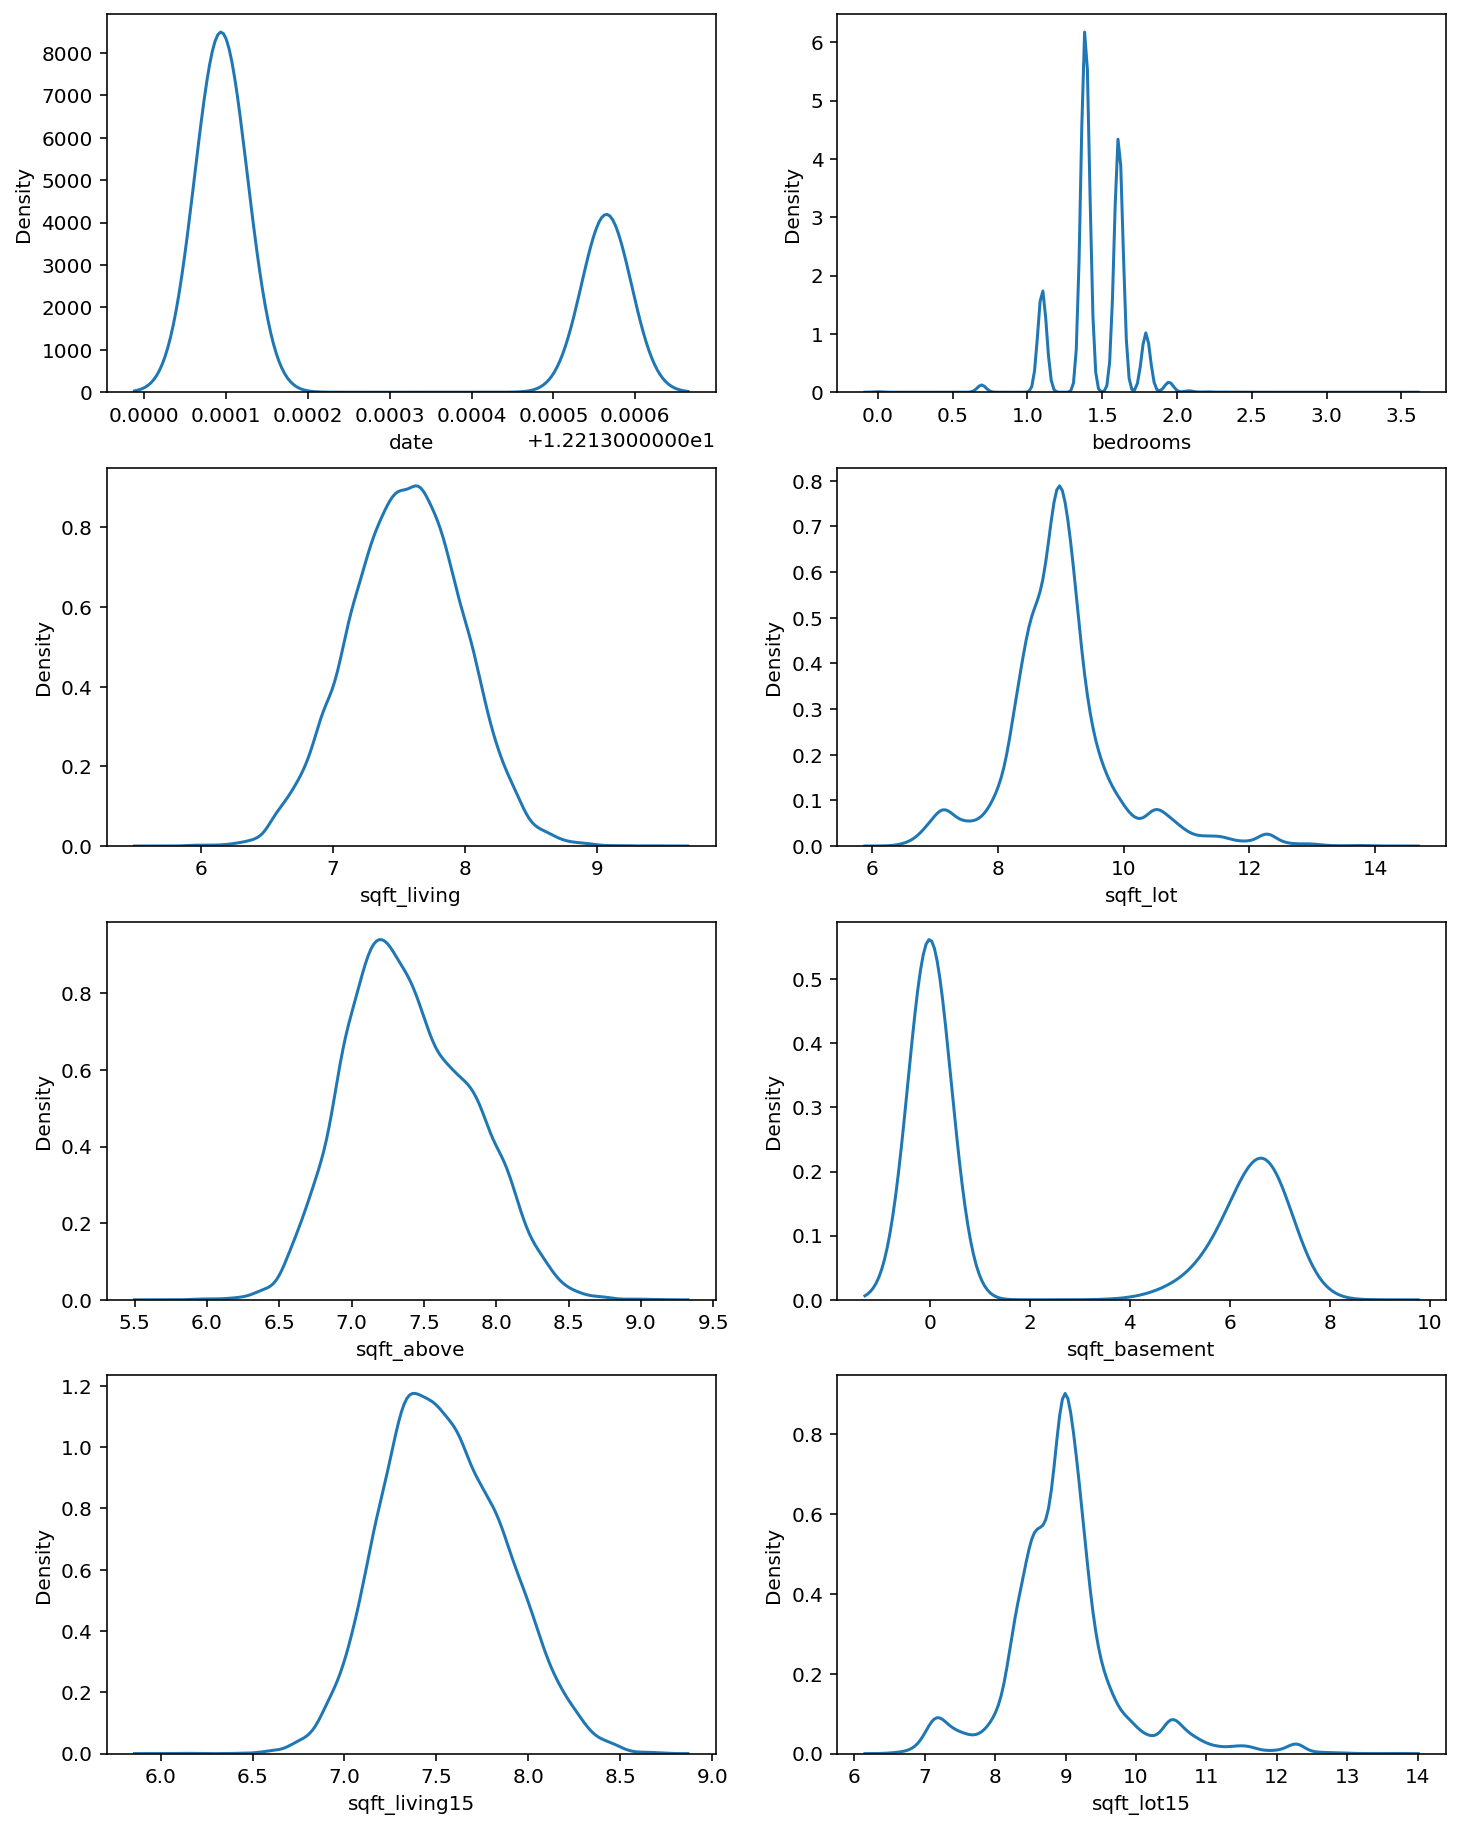

In [22]:
fig, ax = plt.subplots(4, 2, figsize=(12, 16))

count = 0
for row in range(4):
    for col in range(2):
        if count == 8:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        # ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1


어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

### 2-7. 가격 변수 확인 및 로그 변환

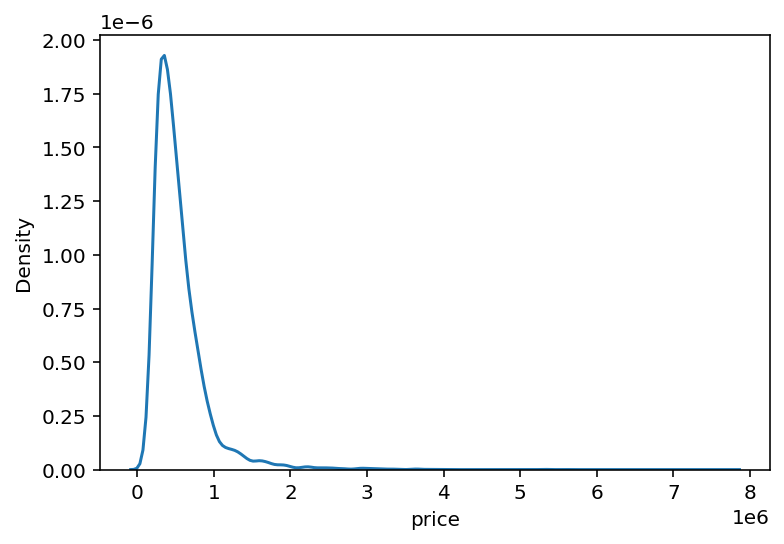

In [23]:
sns.kdeplot(y)
plt.show()

In [24]:
print(min(y), "~", max(y))

78000.0 ~ 7700000.0


11.264476926102367 ~ 15.856731016694035


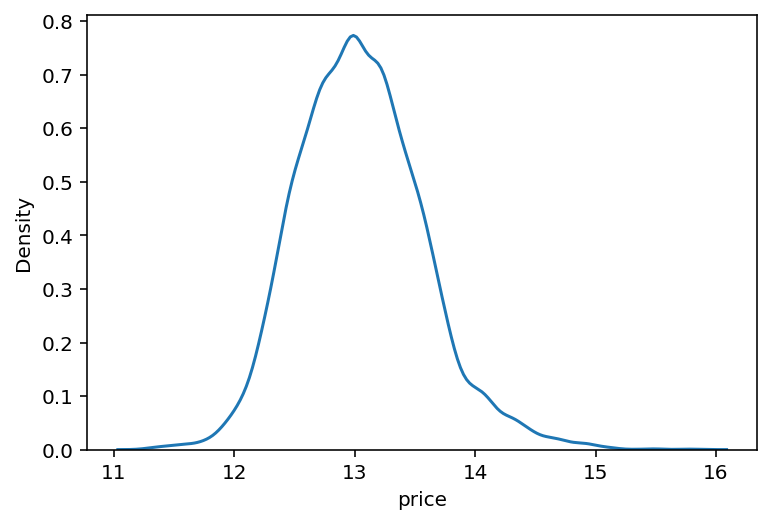

In [25]:
# 로그 변환
y = np.log1p(y)
print(min(y), "~", max(y))

#그래프 확인
sns.kdeplot(y)
plt.show()


| # | 열 이름 | 내용 | 데이터 범위 | 데이터 분포 |  전처리 후 데이터 범위 | 전처리 후 데이터 분포 | 비고 |
|-----:|-----|-----|:-----:|:-----:|:-----:|:-----:|-----|
| 1 | ID | 집을 구분하는 번호 |N/A |N/A | | | |
| 2 | date | 집을 구매한 날짜 |201405 ~ 201505 |양봉 | 12.2130 ~ 12.2136 | 양봉 | |
| 3 | price | 타겟 변수인 집의 가격 | 78000 ~ 7700000 | 왼쪽 극도 치우침 | 11.26 ~ 15.86 | OK | 테스트 데이터(sub)에는 없음 |
| 4 | bedrooms | 침실의 수 | 0 ~ 33 | 왼쪽 극도 치우침 | 0.00 ~ 3.53 | OK | |
| 5 |  bathrooms | 침실당 화장실 개수 | 0.0 ~ 8.0 | 왼쪽 치우침 | | | |
| 6 |  sqft_living | 주거 공간의 평방 피트 | 290 ~ 13540 | 왼쪽 극도 치우침 | 5.67 ~ 9.52 | OK | |
| 7 |  sqft_lot | 부지의 평방 피트 | 520 ~ 1651359 | 왼쪽 극도 치우침 | 6.25 ~ 14.32 | OK | 이상데이터(outlier) 포함 의심됨 |
| 8 | floors | 집의 층 수 | 1.0 ~ 3.5 | 왼쪽 치우침, 양봉 | | | |
| 9 | waterfront | 집의 전방에 강이 흐르는지 유무<br> (a.k.a. 리버뷰) |0 ~ 1 |왼쪽 극도 치우침| | | |
| 10 | view | 집이 얼마나 좋아 보이는지의 정도 |0 ~ 4 |왼쪽 극도 치우침| | | |
| 11 | condition | 집의 전반적인 상태 |1 ~ 5 |보통| | | |
| 12 | grade | King County Grading 시스템 기준으로 <br> 매긴 집의 등급 | 1 ~ 13 |보통 | | | |
| 13 | sqft_above | 지하실을 제외한 평방 피트 | 290 ~ 9410 |왼쪽 극도 치우침| 5.67 ~ 9.15 | OK | |
| 14 | sqft_basement | 지하실의 평방 피트 | 0 ~ 4820 |왼쪽 극도 치우침| 0.00 ~ 8.49 | 양봉 | |
| 15 | yr_built | 집을 지은 연도 | 1900 ~ 2015 | 보통 | | | |
| 16 | yr_renovated | 집을 재건축한 연도 | 0 ~ 2015 |왼쪽 극도 치우침| | |이상데이터 포함 의심됨 |
| 17 | zipcode | 우편번호 | 98001 ~ 98199 | 보통, 양봉 | | | |
| 18 | lat | 위도 | 47.2 ~ 47.8 | 보통, 오른쪽 치우침 | | | |
| 19 | long | 경도 | -122.5 ~ -121.4 | 왼쪽 극도 치우침| | | |
| 20 | sqft_living15 | 2015년 기준 주거 공간의 평방 피트 | 399 ~ 6210 | 왼쪽 치우침 | 5.99 ~ 8.74 | OK | |
| 21 | sqft_lot15 | 2015년 기준 부지의 평방 피트 | 651 ~ 871200 | 왼쪽 극도 치우침 | 6.48 ~ 13.68 | OK | 이상데이터 포함 의심됨|


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  float64
 1   bedrooms       21503 non-null  float64
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  float64
 4   sqft_lot       21503 non-null  float64
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  float64
 11  sqft_basement  21503 non-null  float64
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  float64
 18  sqft_lo

In [27]:
data.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,12.213245,1.452955,2.116042,7.551722,8.990284,1.495140,0.007580,0.234618,3.409710,7.659164,7.396348,2.530451,1971.055016,84.741943,98077.897968,47.560121,-122.213786,7.540336,8.961225
std,0.000220,0.213407,0.770018,0.424418,0.902629,0.540183,0.086737,0.766453,0.650066,1.174422,0.427322,3.170984,29.372398,402.452836,53.489890,0.138615,0.140833,0.327404,0.813163
min,12.213078,0.000000,0.000000,5.673323,6.255750,1.000000,0.000000,0.000000,1.000000,1.000000,5.673323,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,5.991465,6.480045
25%,12.213088,1.386294,1.750000,7.266129,8.525360,1.000000,0.000000,0.000000,3.000000,7.000000,7.090910,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,7.307202,8.537192
50%,12.213103,1.386294,2.250000,7.557473,8.938138,1.500000,0.000000,0.000000,3.000000,7.000000,7.353082,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,7.518064,8.938663
75%,12.213560,1.609438,2.500000,7.844241,9.276783,2.000000,0.000000,0.000000,4.000000,8.000000,7.701200,6.329721,1997.000000,0.000000,98117.000000,47.678100,-122.125000,7.771067,9.218904
max,12.213574,3.526361,8.000000,9.513477,14.317110,3.500000,1.000000,4.000000,5.000000,13.000000,9.149634,8.480737,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,8.734077,13.677628


- 그러면 여기까지 로그 변환이 필요한 데이터에 대해 처리를 마무리하였으니, 아래와 같이 전체 데이터를 다시 나누어 줍니다.
  - 위에서 저장해두었던 train_len을 인덱스로 활용해서
  - :train_len까지는 학습 데이터, 즉 x에 저장하고, 
  - train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장합니다.

In [28]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [29]:
import copy

train = copy.deepcopy(x)
test = copy.deepcopy(sub)

print(train.shape)
print(test.shape)


(15035, 19)
(6468, 19)


#### 데이터 표준화 (보류) - 제출점수 미달시 고려

## 3. 모델링

#### RMSE 계산 함수 정의

- 필요 함수 import
  - train_test_split 함수: 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나눔 
  - mean_squared_error 함수: RMSE 점수 계산에 필요

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


- RMSE 계산 함수 정의

In [31]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢



#### 모델별 학습 및 예측 후 RMSE값 돌려주는 함수 정의
- for문, 클래스의 name 속성 사용

In [32]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
        #각 모델의 이름은 클래스의 name 속성에 접근해서 얻음
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리. 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 모델 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # 예측 결과의 RMSE값 저장
        df[model_name] = rmse(y_test, y_pred)
        # DataFrame에 모델별 RMSE값 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

print('얍💢')

얍💢


### 3-1. 네 가지 모델 불러오기
- 네 가지 모델: XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 

In [33]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


- 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.
 - random_state 값을 특정 값으로 고정: 베이스라인에서부터 시작해서 다양한 실험을 통한 성능 개선 검증을 위해, 머신러닝 학습 결과가 항상 동일하게 재현되도록 (radom seed로 인한 변동성 제거) 

In [34]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 (deafult=None) 
random_state=2020        # 고정값 세팅 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


### 3-2. 네 가지 모델에 대한 RMSE값 확인

In [35]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128370.486911
RandomForestRegressor,125258.006405
LGBMRegressor,111906.268088
XGBRegressor,110514.289485


#### [분석]
- **LGBM 모델**과 **XGB 모델**이 상대적으로 우수해 보임

## 4. 각 모델에 대해 최적 파라미터 결정
- 다양한 하이퍼 파라미터로 실험: GridSearchCV 클래스 활용
- GridSearchCV에 입력되는 인자들
  - param_grid: 탐색할 파라미터의 종류 (딕셔너리로 입력)
  - scoring: 모델의 성능을 평가할 지표
  - cv: cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
  - verbose: 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
  -  n_jobs: 그리드 탐색을 진행하면서 사용할 CPU의 개수  


#### GridSearchCV 클래스 import

In [36]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


#### (함수 정의) 입력되는 "모델+파라미터"에 대해 RMSLE값을 반환해주는 함수 정의
- 다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현
  1. GridSearchCV 모델로 `model`을 초기화
  2. 모델을 fitting 
  3. params, score에 각 조합에 대한 결과를 저장 
  4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환

In [37]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    #grid_model.best_estimator_
    #grid_model.best_params_

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results
print('얍💢')

얍💢


### 4-1. LightGBM 모델 최적화
- param_grid에 탐색할 하이퍼 파라미터 입력
- 모델은 LightGBM(lgbm) 사용

In [38]:
#param_grid = { 'n_estimators': [300, 350, 500], 'max_depth': [10, 15, 20],  }
param_grid = { 'n_estimators': range(200, 401, 50), 'max_depth': range(10, 31, 5), }

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,max_depth,n_estimators,score,RMSLE
12,20,300,-0.026090,0.161525
22,30,300,-0.026090,0.161525
17,25,300,-0.026090,0.161525
3,10,350,-0.026107,0.161577
4,10,400,-0.026118,0.161609
2,10,300,-0.026126,0.161636
21,30,250,-0.026126,0.161636
16,25,250,-0.026126,0.161636
11,20,250,-0.026126,0.161636
1,10,250,-0.026135,0.161662


#### [분석]
- **최초 탐색**: max_depth = range(5, 20, 5), n_estimators = range(50, 500, 50) <br> -> 총 3 x 9 = 27개 경우 탐색
  - **결과**: max_depth = 10, n_estimators = 350에서 RMSLE = 0.161577
  - 제출용 파일 생성 후 업로드: 결과 점수 111,795.72점. 기준 점수에 1,795점 초과
<br> <br>
- **추가 탐색**: max_depth = range(10, 31, 5), n_estimators = range(200, 401, 50) 으로 구간 재조정 후 탐색
  - **결과**:  **max_depth = 20**, **n_estimators = 300**에서 **RMSLE = 0.161525**
  - 제출용 파일 생성 후 업로드: **<u>결과 점수 107,741.43점</u>** <u>(기준 점수 110,000점 이하 달성)</u>
    - 맨 아래 결과 정리 부분에 캐글 스크린샷 첨부
  - Stop!

### 4-2. XGBoost 모델 최적화
- param_grid에 탐색할 하이퍼 파라미터 입력
- 모델은 XGBRegressor 사용

In [39]:
param_grid = { 'n_estimators': [450, 500, 550, 600], 'max_depth': [5], }
#param_grid = { 'n_estimators': range(50, 500, 50), 'max_depth': range(5, 20, 5), }

model = xgboost
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

#xgboost = XGBRegressor(random_state=random_state)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


,max_depth,n_estimators,score,RMSLE
0,5,450,-0.029148,0.170728
1,5,500,-0.029200,0.170881
2,5,550,-0.029306,0.171191
3,5,600,-0.029423,0.171531


#### [분석]
- **최초 탐색**: max_depth = range(5, 20, 5), n_estimators = range(50, 500, 50) <br> -> 총 3 x 9 = 27개 경우 탐색
  - **결과**: max_depth = 5, n_estimators = 450에서 RMSLE = 0.170728
    - 구글코랩에서 실행시 같은 하이퍼파라미터에서 RMSLE = 0.161869 (최적화 실행이 다르게 이루어지는지?????)
    - max_depth = 5일 때의 값이 최소로 파악됨
<br> <br>
- **추가 탐색**: max_depth = 5로 고정 후, n_estimators = [450, 500, 550, 600] 으로 조정 후 탐색
  - **결과**: max_depth = 5, n_estimators = 450에서 **RMSLE = 0.170728**로 최소
  - RMSLE값이 전체적으로 LGBM 모델값(최소값 0.161525)보다 나쁘므로 추가적인 탐색 중지

### 4-3. Gradient Boost 모델 최적화 
- param_grid에 탐색할 하이퍼 파라미터 입력
- 모델은 GradientBoostingRegressor 사용

In [45]:
param_grid = { 'n_estimators': [350, 400, 450, 500], 'max_depth': [5], }
#param_grid = { 'n_estimators': range(50, 500, 50), 'max_depth': range(5, 20, 5), }

model = gboost
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

#gboost = GradientBoostingRegressor(random_state=random_state)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
1,5,400,-0.026711,0.163437
2,5,450,-0.026715,0.163448
3,5,500,-0.026757,0.163575
0,5,350,-0.026764,0.163596


[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=250; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=250; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=350; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=350; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.8s
[CV] END .....................max_depth=15, n_estimators=200; total time=   0.5s
[CV] END ...................

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=250; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=350; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=400; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=400; total time=   1.3s
[CV] END .....................max_depth=15, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=15, n_estimators=250; total time=   0.9s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.1s
[CV] END .....................max_depth=15, n_estimators=300; total time=   1.0s
[CV] END .....................max_depth=15, n_estimators=350; total time=   1.1s
[CV] END ...................

#### [분석]
- **최초 탐색**: max_depth = range(5, 20, 5), n_estimators = range(50, 500, 50) <br> -> 총 3 x 9 = 27개 경우 탐색
  - **결과**: max_depth = 5, n_estimators = 400에서 RMSLE = 0.163437
    - max_depth = 5일 때의 값이 최소로 파악됨
<br> <br>
- **추가 탐색**: max_depth = 5로 고정 후, n_estimators = [350, 400, 450, 500] 으로 조정 후 탐색
  - **결과**: max_depth = 5, n_estimators = 400에서 **RMSLE = 0.163437**로 최소
  - RMSLE값이 전체적으로 LGBM 모델값(최소값 0.161525)보다 나쁘므로 추가적인 탐색 중지

### 4-4. Random Forest 모델 최적화 
- param_grid에 탐색할 하이퍼 파라미터 입력
- 모델은 RandomForestRegressor 사용

In [41]:
param_grid = { 'n_estimators': [50, 500], 'max_depth': [3, 5, 10], }
# param_grid = { 'n_estimators': range(200, 501, 50), 'max_depth': range(5, 20, 5), }

model = rdforest
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

#rdforest = RandomForestRegressor(random_state=random_state)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,500,-0.034906,0.186830
4,10,50,-0.035424,0.188212
3,5,500,-0.058373,0.241604
2,5,50,-0.058567,0.242007
1,3,500,-0.085521,0.292440
0,3,50,-0.085717,0.292774


#### [분석]
- **최초 탐색**: max_depth = range(5, 20, 5), n_estimators = range(50, 501, 50) <br> -> 총 3 x 10 = 30개 경우 탐색
  - **결과**: max_depth = 10, n_estimators = 500에서 RMSLE = 0.186830
    - max_depth = 10 이하일 때의 값이 낮은 것으로 파악됨
<br> <br>
- **추가 탐색**: max_depth = [3, 5, 10], n_estimators = [50, 500] 으로 조정 후 탐색
  - **결과**: max_depth = 10, n_estimators = 500에서 **RMSLE = 0.186830**으로 최소
  - RMSLE값이 전체적으로 LGBM 모델값(최소값 0.161525)보다 나쁘므로 추가적인 탐색 중지

## 5. 결과 제출하기

#### 최적화된 파라미터로 "모델 학습 -> 예측 결과 생성 -> 예측치 파일 생성"하는 함수 정의

In [42]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    
    #학습
    model.fit(train, y)

    #예측 결과 생성
    prediction = model.predict(test)

    #예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌림
    prediction = np.expm1(prediction)

    # sample_submission.csv 파일 확인

    # 아이펠 폴더 파일 경로 지정
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    # 구글 드라이브 파일 경로 지정
    #data_dir = '/content/drive/MyDrive/AIFFEL/kaggle_kakr_housing/data'
    
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    #위의 데이터프레임에 우리의 모델이 예측한 값을 덮어써서 제출할 데이터 완성!
    submission['price'] = prediction
    submission.head()

    #위의 데이터를 csv 파일로 저장
    #파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어서 제출 파일들을 깔끔하게 관리
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

print('얍💢')

얍💢


#### 최적화된 파라미터로 모델을 학습시킨 후 예측 결과 저장
- (인풋) 해당 파라미터로 구성된 모델

In [43]:
model = LGBMRegressor(max_depth=10, n_estimators=350, random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.161577')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161577.csv saved!


In [44]:
model = LGBMRegressor(max_depth=20, n_estimators=300, random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.161525')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161525.csv saved!


## 6. 프로젝트 평가

| 평가문항	| 상세기준 |
|:--:|:--:|
|1. 캐글 데이터분석 전 과정이 성공적으로 진행되었는가?| 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 <br> 캐글 submission까지 진행되었다.|
|2. 전처리, 학습과정 및 결과에 대한 설명이 <br> 시각화를 포함하여 체계적으로 진행되었는가?|제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 <br> 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.|
|3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?| 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 <br> 최적화 기법을 통해 캐글 리더보드의 <br> Private score 기준 110000 이하의 점수를 얻었다.|



### 6-1. 캐글 데이터 분석 전 과정 정리
아래 순서로 진행하였음:
<br> <br>
**1. 데이터 살펴보기**  
   1-1. 데이터 불러오기  
   1-2. 데이터 구성 확인  
   1-3. 학습데이터에서 라벨 제거하기  
   1-4. 학습데이터와 결과 예측용 데이터 합치기  
**2. 데이터 전처리**  
   2-1. 결측치 확인  
   2-2. 결측치 개수 다시 확인하기  
   2-3. id 변수 정리   
   2-4. date 변수 정리  
   2-5. 각 변수들의 분포 확인  
   2-6. 치우친 컬럼(변수) 로그 변환  
   2-7. 가격 변수 확인 및 로그 변환  
**3. 모델링**  
   3-1. 네 가지 모델 불러오기  
   3-2. 네가지 모델에 대한 RMSE값 확인  
**4. 각 모델에 대한 최적 파라미터 결정**  
   4-1. Light GBM 모델 최적화  
   4-2. XGBoost 모델 최적화  
   4-3. Gradient Boost 모델 최적화  
   4-4. Random Forest 모델 최적화  
**5. 결과 제출하기**  
**6. 프로젝트 평가** 

### 6-2. 파라미터 튜닝 결과 정리

1. 4개 모델에 대해 최초 탐색 조건으로 성능 평가 결과 Light GBM(LGBM)모델이 제일 우수한 것으로 보임
   - 최초 탐색 조건: max_depth = range(5, 20, 5), n_estimators = range(50, 500, 50) -> 총 3 x 9 = 27개 경우 탐색
2. 같은 탐색 조건에 대해 모델별 실행시간 차이가 많이 남
   - LGBM이 가장 빠르고, Gradient Boost(GB)와 Random Forest(RF)가 비슷하며, XGBoost(XGB)는 특별히 느림
   - XGB의 경우, 아이펠 실행 결과와 구글코랩 실행 결과가 다르게 나옴 -> 내부적인 종료 조건 차이가 있을 수 있음
   - 각 모델별 최적화 탐색을 충분히 하기에는 시간적 제약이 있었음
3. 위와 같은 연유로 LGBM으로만 추가 탐색 실행
   - 우연히 제출 조건에 맞는 파라미터 발견
   - 캐글 최고 점수가 6만점대인 것을 보면 현재 107,741점에서 개선의 여지가 많음 
4. 점수를 낮추기 위해, 즉 예측 정확도를 높이기 위해 추가로 할 수 있는 사항
   - 데이터 전처리 측면
     - StandardScaler를 적용하여 모든 변수들을 정규화: 스케일을 동일하게
     - 이상데이터(outlier) 제거 또는 평균치 적용
     - 특성공학(feature engineering)을 이용한 변수 추가
   - 파라미터 최적화 측면
     - 본 프로젝트에서는 GridSearch를 사용
       - 시행착오에 의존하는 주먹구구식 방법에 가까움
     - Random Search 사용
     - 더 나아가서는 AutoML 모색
     - 튜닝 대상 파라미터로는 트리별 깊이와 트리 수만 고려했으나 learning rate 등 추가적인 파라미터 튜닝

### 6-3. 캐글 제출 결과

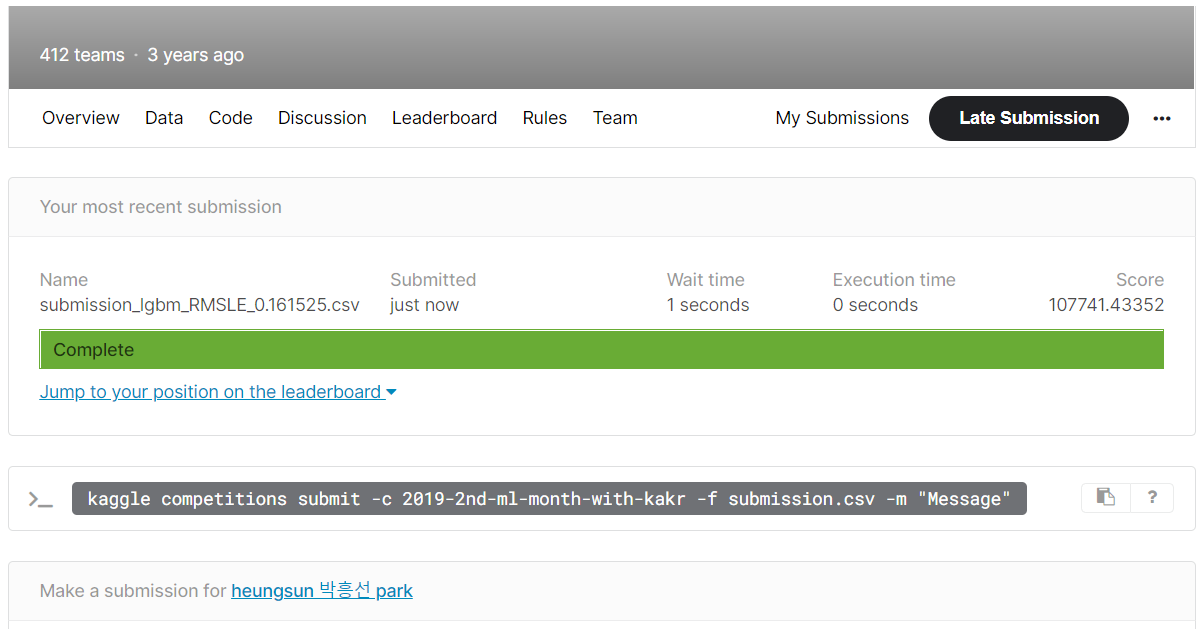